In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
sc.set_figure_params(dpi_save=300)

/Users/Future/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Supplemental Figure 4/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

### Figure 4.a

In [3]:
pbmc = sc.read("../data/train_pbmc.h5ad")
pbmc = pbmc[~((pbmc.obs["condition"] == "stimulated") & (pbmc.obs["cell_type"] == "CD4T"))]
pbmc

View of AnnData object with n_obs × n_vars = 13766 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [6]:
pbmc.obs.groupby(['cell_type']).size()

cell_type
CD4T           2437
CD14+Mono      2561
B              1811
CD8T           1115
NK             1163
FCGR3A+Mono    3601
Dendritic      1078
dtype: int64

In [7]:
pbmc.obs.groupby(['condition']).size()

condition
control       8007
stimulated    5759
dtype: int64

In [5]:
def replace_conditions(adata):
    adata.obs["condition"].replace("CD4T_ctrl", "CD4-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD4T_real_stim", "CD4-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD4T_pred_stim", "CD4-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD8T_ctrl", "CD8-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD8T_real_stim", "CD8-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD8T_pred_stim", "CD8-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("Dendritic_ctrl", "DC_ctrl", inplace=True)
    adata.obs["condition"].replace("Dendritic_real_stim", "DC_real_stim", inplace=True)
    adata.obs["condition"].replace("Dendritic_pred_stim", "DC_pred_stim", inplace=True)

    adata.obs["condition"].replace("FCGR3A+Mono_ctrl", "F-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_real_stim", "F-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_pred_stim", "F-Mono_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD14+Mono_ctrl", "CD14-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_real_stim", "CD14-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_pred_stim", "CD14-Mono_pred_stim", inplace=True)
def replace_cell_types(adata):
    adata.obs["cell_type"].replace("CD4T", "CD4-T", inplace=True)
    adata.obs["cell_type"].replace("CD8T", "CD8-T", inplace=True)
    adata.obs["cell_type"].replace("Dendritic", "DC", inplace=True)
    adata.obs["cell_type"].replace("FCGR3A+Mono", "F-Mono", inplace=True)
    adata.obs["cell_type"].replace("CD14+Mono", "CD14-Mono", inplace=True)

In [14]:
def visualize_latent(network, model_name, figure):
    true_labels, _ = scgen.label_encoder(pbmc)
    if model_name == "CVAE":
        latent = network.to_latent(pbmc.X.A, labels=true_labels)
    else:
        latent = network.to_latent(pbmc.X.A)
    latent = sc.AnnData(X=latent,
                        obs={"condition": pbmc.obs["condition"].tolist(),
                             "cell_type": pbmc.obs["cell_type"].tolist()})
    replace_cell_types(latent)
    sc.pp.neighbors(latent)
    sc.tl.umap(latent)
    if model_name == "scGen":
        sc.pl.umap(latent, color=["condition"], title="",
                   palette=["#96a1a3", "#A4E804"],
                   save=f"_latent_conditions.pdf",
                   frameon=False,
                   legend_fontsize=22,
                   show=True)
        sc.pl.umap(latent, color=["cell_type"], title="",
                   save=f"_latent_celltypes.pdf",
                   frameon=False,
                   legend_fontsize=22,
                   show=True)
    else:
        sc.pl.umap(latent, color=["condition"], title="",
                   palette=["#96a1a3", "#A4E804"],
                   save=f"_latent_conditions.pdf",
                   frameon=False,
                   legend_loc=False,
                   show=True)
        sc.pl.umap(latent, color=["cell_type"], title="",
                   save=f"_latent_celltypes.pdf",
                   frameon=False,
                   legend_loc=False,
                   show=True)
    
    os.rename(src=os.path.join(path_to_save, "umap_latent_conditions.pdf"), 
              dst=os.path.join(path_to_save, f"SupplFig4{figure}_{model_name}_umap_conditions.pdf"))

    os.rename(src=os.path.join(path_to_save, "umap_latent_celltypes.pdf"), 
              dst=os.path.join(path_to_save, f"SupplFig4{figure}_{model_name}_umap_celltypes.pdf"))

INFO:tensorflow:Restoring parameters from ../models/CVAE/pbmc/all/models/scgen
         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'condition' as categorical
... storing 'cell_type' as categorical


saving figure to file ../results/Figures/Supplemental Figure 4/umap_latent_conditions.pdf


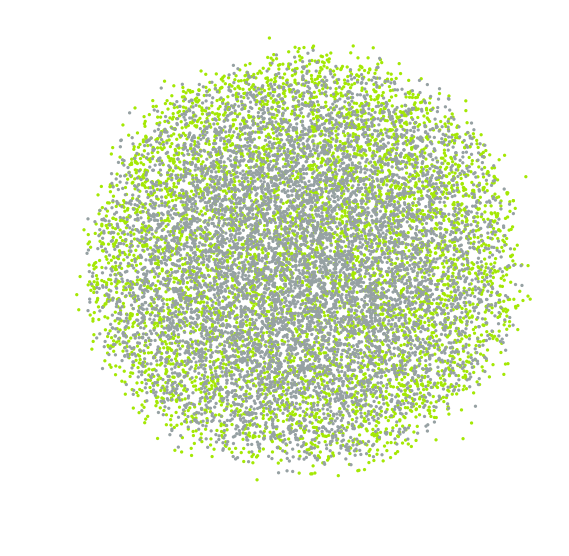

saving figure to file ../results/Figures/Supplemental Figure 4/umap_latent_celltypes.pdf


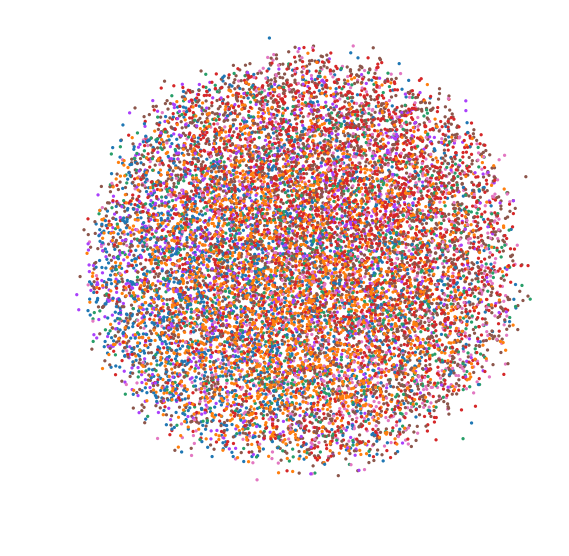

In [15]:
cvae = scgen.CVAE(x_dimension=pbmc.shape[1], z_dimension=100, model_path="../models/CVAE/pbmc/all/models/scgen")
cvae.restore_model()
visualize_latent(cvae, "CVAE", "a")

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen
         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'condition' as categorical
... storing 'cell_type' as categorical


saving figure to file ../results/Figures/Supplemental Figure 4/umap_latent_conditions.pdf


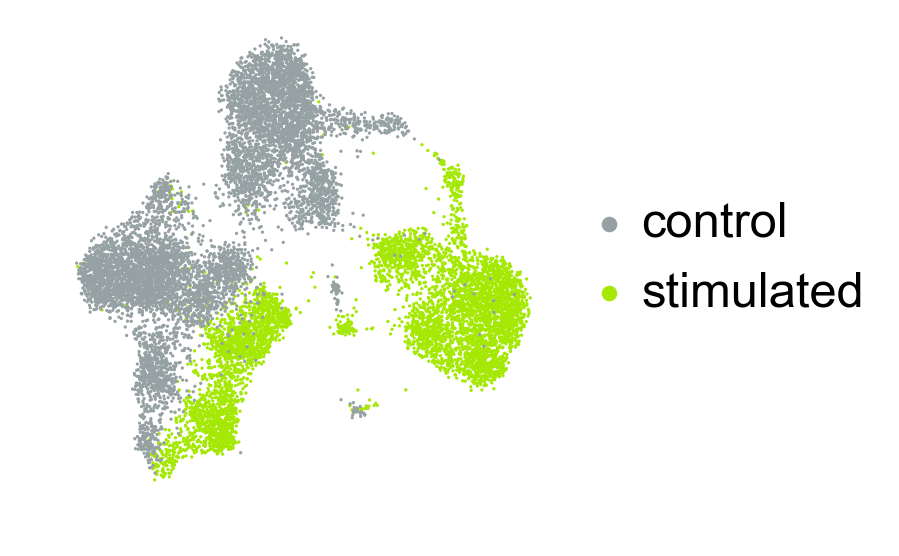

saving figure to file ../results/Figures/Supplemental Figure 4/umap_latent_celltypes.pdf


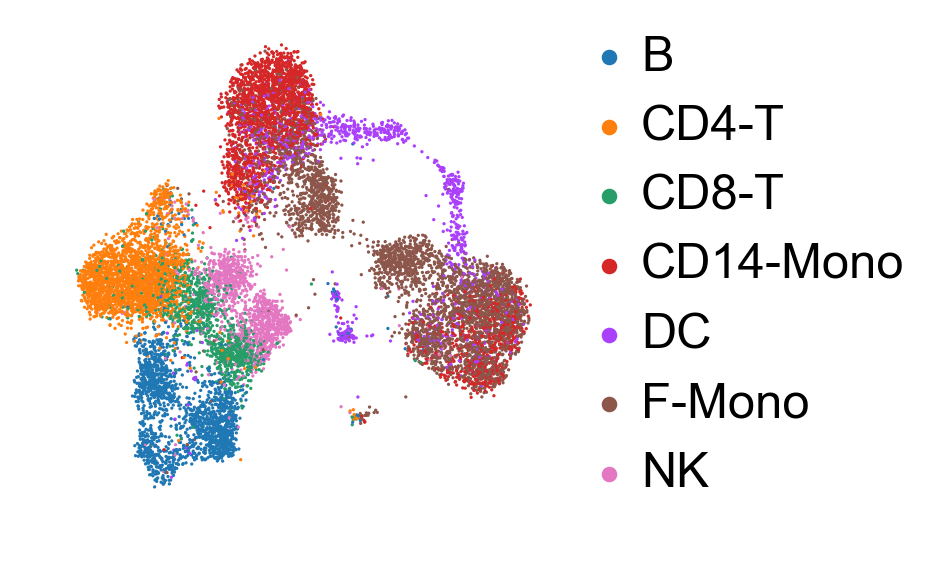

In [16]:
scGen = scgen.VAEArith(x_dimension=pbmc.shape[1], z_dimension=100, model_path="../models/scGen/pbmc/CD4T/scgen")
scGen.restore_model()
visualize_latent(scGen, "scGen", "c")

In [ ]:
%%bash
python ../code/st_gan.py latent

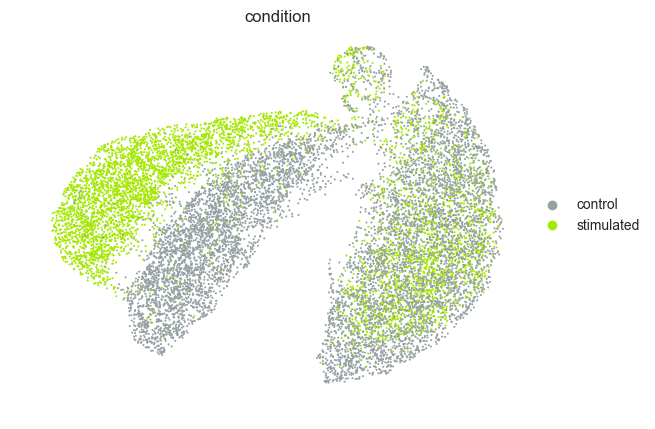

In [17]:
from IPython.display import Image
Image(os.path.join(path_to_save, "SupplFig4b_style_transfer_condition.png"))

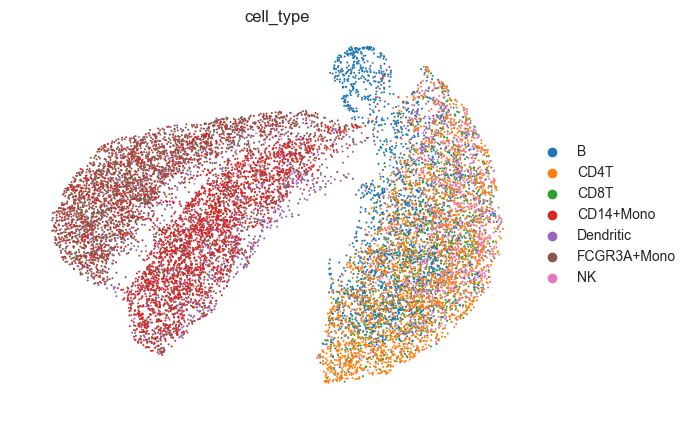

In [18]:
Image(os.path.join(path_to_save, "SupplFig4b_style_transfer_celltype.png"))